# Shallow Water Tutorial 1D with Numpy (Simple)


::: {.callout-note title="Reference"}
The following the model is described in the paper: 

```
 @article{Delestre_2013, 
 title={SWASHES: a compilation of Shallow Water Analytic Solutions for Hydraulic and Environmental Studies}, 
 volume={72}, 
 ISSN={0271-2091, 1097-0363}, DOI={10.1002/fld.3741}, 
 note={arXiv:1110.0288 [physics]}, 
 number={3}, 
 journal={International Journal for Numerical Methods in Fluids}, 
 author={Delestre, Olivier and Lucas, Carine and Ksinant, Pierre-Antoine and Darboux, Frédéric and Laguerre, Christian and Vo, Thi Ngoc Tuoi and James, Francois and Cordier, Stephane}, 
 year={2013}, 
 month=may, 
 pages={269–300} 
}
```

:::

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import pytest
from sympy import Matrix
import sympy as sp
import pytest

from library.zoomy_core.fvm.solver_numpy import HyperbolicSolver, Settings
import library.zoomy_core.fvm.timestepping as timestepping
import library.zoomy_core.fvm.nonconservative_flux as nc_flux
from library.zoomy_core.model.basemodel import Model
from attr import field, define
import library.zoomy_core.model.initial_conditions as IC
import library.zoomy_core.model.boundary_conditions as BC
import library.zoomy_core.misc.io as io
from library.zoomy_core.mesh.mesh import compute_derivatives
from library.zoomy_core.misc.misc import Zstruct, ZArray
from tests.pdesoft import plots_paper


import library.zoomy_core.mesh.mesh as petscMesh
import library.zoomy_core.postprocessing.postprocessing as postprocessing


In [2]:
@define(frozen=True, slots=True, kw_only=True)
class SWE(Model):
    dimension: int = 1
    variables: Zstruct = field(init=False, default=dimension + 1)
    aux_variables: Zstruct = field(default=1)
    _default_parameters: dict = field(
        init=False,
        factory=lambda: {"g": 9.81, "ex": 0.0, "ey": 0.0, "ez": 1.0}
        )


    def project_2d_to_3d(self):
        out = ZArray.zeros(6)
        dim = self.dimension
        z = self.position[2]
        b = 0
        h = self.variables[0]
        U = [hu / h for hu in self.variables[1:1+dim]]
        rho_w = 1000.
        g = 9.81
        out[0] = b
        out[1] = h
        out[2] = U[0]
        out[3] = 0 if dim == 1 else U[1]
        out[4] = 0
        out[5] = rho_w * g * h * (1-z)
        return out

    def flux(self):
        dim = self.dimension
        h = self.variables[0]
        U = Matrix([hu / h for hu in self.variables[1:1+dim]])
        g = self.parameters.g
        I = Matrix.eye(dim)
        F = Matrix.zeros(self.variables.length(), dim)
        # F = ZArray.zeros(dim, self.variables.length())
        F[0, :] = (h * U)
        F[1:, :] = h * U * U.T + g/2 * h**2 * I
        
        # flux = [ZArray.zeros(self.variables.length()) for _ in range(dim)]
        # for d in range(dim):
        #     for i in range(self.variables.length()):
        #         flux[d][i] = F[i, d]
        # return flux
        # return ZArray(list(F.T))
        return F

In [3]:

bcs = BC.BoundaryConditions(
    [
        BC.Extrapolation(tag="left"),
        BC.Extrapolation(tag="right"),
    ]
)

def custom_ic(x):
    Q = np.zeros(2, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = SWE(
    boundary_conditions=bcs,
    initial_conditions=ic,
)

main_dir = os.getenv("ZOOMY_DIR")
# mesh = petscMesh.Mesh.from_gmsh(
#     os.path.join(main_dir, "meshes/channel_quad_2d/mesh.msh")
# )

mesh = petscMesh.Mesh.create_1d(domain=(0.0, 10.0), n_inner_cells=500)

class SWESolver(HyperbolicSolver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        dudx = compute_derivatives(Q[1]/Q[0], mesh, derivatives_multi_index=[[0, 0]])[:,0]
        Qaux[0]=dudx
        return Qaux
    
settings = Settings(name="ShallowWater", output=Zstruct(directory="outputs/shallow_water_1d", filename="swe", clean_directory=True))


In [4]:
solver = SWESolver(time_end=6.0, settings=settings, compute_dt=timestepping.adaptive(CFL=0.95), nc_flux=nc_flux.segmentpath())
Qnew, Qaux = solver.solve(mesh, model)

2025-11-05 08:38:47.465 | INFO     | library.zoomy_core.fvm.solver_numpy:run:293 - iteration: 10, time: 0.718260, dt: 0.067958, next write at time: 0.666667
2025-11-05 08:38:47.490 | INFO     | library.zoomy_core.fvm.solver_numpy:run:293 - iteration: 20, time: 1.392979, dt: 0.067263, next write at time: 1.333333
2025-11-05 08:38:47.514 | INFO     | library.zoomy_core.fvm.solver_numpy:run:293 - iteration: 30, time: 2.064282, dt: 0.067054, next write at time: 2.000000
2025-11-05 08:38:47.542 | INFO     | library.zoomy_core.fvm.solver_numpy:run:293 - iteration: 40, time: 2.734237, dt: 0.066956, next write at time: 3.333333
2025-11-05 08:38:47.566 | INFO     | library.zoomy_core.fvm.solver_numpy:run:293 - iteration: 50, time: 3.403455, dt: 0.066898, next write at time: 4.000000
2025-11-05 08:38:47.591 | INFO     | library.zoomy_core.fvm.solver_numpy:run:293 - iteration: 60, time: 4.072203, dt: 0.066858, next write at time: 4.666667
2025-11-05 08:38:47.628 | INFO     | library.zoomy_core.fv

In [5]:
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.output.filename}.h5"))
postprocessing.vtk_project_2d_to_3d(model, settings, filename='out_3d')

2025-11-05 08:38:47.809 | INFO     | library.zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:68 - Converted snapshot 0/10
2025-11-05 08:38:47.811 | INFO     | library.zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:68 - Converted snapshot 1/10
2025-11-05 08:38:47.813 | INFO     | library.zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:68 - Converted snapshot 2/10
2025-11-05 08:38:47.814 | INFO     | library.zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:68 - Converted snapshot 3/10
2025-11-05 08:38:47.816 | INFO     | library.zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:68 - Converted snapshot 4/10
2025-11-05 08:38:47.819 | INFO     | library.zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:68 - Converted snapshot 5/10
2025-11-05 08:38:47.820 | INFO     | library.zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:68 - Converted snapshot 6/10
2025-11-05 08:38:47.822 | INFO     | library.zoo

{'length': 10.0, 'width': None, 'dx': 0.2, 'dy': None, 'ncellx': 50.0, 'ncelly': None}


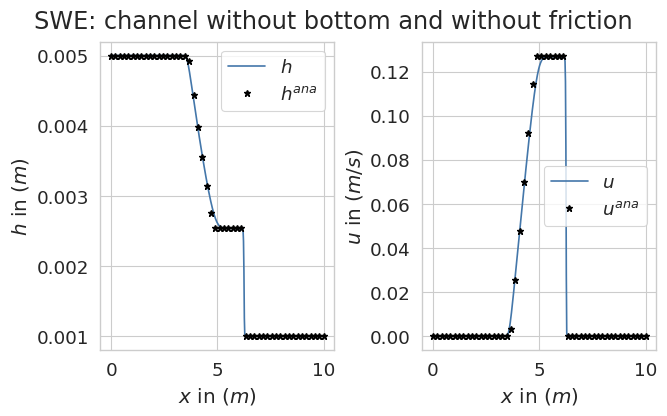

In [6]:
fig = plots_paper.plot_swe(os.path.join(settings.output.directory, settings.output.filename + ".h5"))

In [7]:
@pytest.mark.nbworking
def test_working():
    assert True